# Vaccination Tweets: EDA, Sentiment Analyis

Agenda:
+ Frequency
    + most frequent words in tweets
    + look at most popular hashtags (in 'text' and in 'hashtags')
    + what is the most tweeted-about vaccine?
+ Time
    + Which vaccine "trends" in tweets? (time series)
    + Do different vaccines trend at different times as tweet subjects?

+ Sentiment
    + vaccine most closely connected to negative/positive sentiment
    + create a measure of influence (followers, retweets, user_favourites, user_verified)
    + most influential sources who tweet positive/negative/neutral about vaccines in general
    + locations (uncleared) with the most positive, negative, neutral tweets
    + Positive, negative, neutral: which gets more retweets / are liked more?
 
+ Prediction
    + what determines most strongly whether a tweet is positive or negative? influence(popularity), location, textlength
    + does the ratio between positive an negative tweets change over time?
+ topic modelling
    + what are negative and positive tweets about? Does it make sense? Topic=Vaccination
    + Topic "progress"
    
+ Are Tweets useless
    + any attitudes?

(Measuring general attitude via tweets: how many people tweet by population, how many by population tweet about vaccines, how well are vaccinations monitored)
(negative: we do not know what is commented on in a negative way. Negative does not necessarily mean that there is a negative opinion about vaccines or a specific vaccine. Negative evlaluation in the context of a tweet. It can also concern the process.)
Look at full tweets and compare. Imbalance?

+ id: tweet identification number
+ user_name: name of user
+ user_location: location of user
+ user_description: self-description of user
+ user_created: date when account was opened
+ user_followers: number of users who follow a specified user
+ user_friends: number of users which a specified user follows
+ user_favourites: 
+ user_verified: accounts of officially recognized organizations, users with many followers
+ date: date of tweet
+ text: text of the tweet
+ hashtags: hashtags used
+ source: 
+ retweets: number of retweets
+ favorites: 
+ is_retweet: is a retweet or not (true or false)

Added:
+ day: day of the tweet
+ influence: rating the influence of user based on verification status, followers, average retweets, average followers, average user favourites

# Explanation of used methods

**VADER** ("Valence Aware Dictionary and sEntiment Reasoner") library:

Pretrained lexikon for sentiment analysis in Python, specialized on social media text analysis. Returns probabilities for `pos`, `neg`, `neu`, which add to 1 as well as a `compound` score between -1 and 1. Conventional thresholds are >=0.5 (positive), between -0.5 and 0.5 (neutral) and <=-0.5 (negative).

**TextBlob** sentiment analysis gives a text polarity score between -1 and 1 and a subjectivity score between 0 and 1.

Both analyses are carried out on the dataset with adequate preprocessing, which differs between the cases.

To generate a validation basis for an additional model, high-level agreement or unanimity between classifications based on **VADER** and **TextBlob** will be used as a target for a training and test set.

Vader, TextBlob, semi-supervised learning

Why two/three? Tweets in the dataset are incomplete. While VADER is sensitive to peculiarities of social media messages (e.g. emojis, capital letters) TextBlob is not. Missing indicators of temperament due to cut off messages should not receive an unduly high weight. While VADER is applied with restricted text cleaning, running TextBlob over a more thoroughly cleaned text basis might be a good control.


In [74]:
# Main data packages. 
import numpy as np
import pandas as pd
from datetime import datetime

import pickle

#text processing, NLP modules
import re
import string
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import *
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

#sentiment analysis
from nltk.sentiment import SentimentIntensityAnalyzer
from sklearn.feature_extraction.text import CountVectorizer
#plotting
import seaborn as sns
import matplotlib.pyplot as plt

import plotly.express as px

import warnings
warnings.filterwarnings('ignore')

In [75]:
#nltk.download('punkt')
#nltk.download('wordnet')

In [76]:
df = pd.read_csv("Data/vaccination_tweets.csv")

In [77]:
df_tweety = df.copy()

In [78]:
df_tweety['user_name'].nunique()

21628

# Cleaning 'text' (round 1)

### Various character and symbol removals, lowercase()

def CleanTweet(x):
    #remove twitter handlers
    x = re.sub('@[^\s]+','',x)
    #remove hashtags
    x = re.sub(r'\B#\S+','',x)
    #remove urls
    x = re.sub(r'https?:\/\/[A-Za-z0-9\.\/]+', '', x)
    #remove special characters
    x = re.findall(r'\w+', x)
    #remove single characters
    x = re.sub(r'\s+[a-zA-Z]\s+', '', x)
    #substitute multiple spaces with single space
    x = re.sub(r'\s+', ' ', x, flags=re.I)
    return x

In [79]:
#df_tweety.text = df_tweety.text.apply(CleanTweet)

In [80]:
#remove twitter handlers
df_tweety.text = df_tweety.text.apply(lambda x:re.sub('@[^\s]+','',x))

#remove hashtags
df_tweety.text = df_tweety.text.apply(lambda x:re.sub(r'\B#\S+','',x))

#remove URLs
df_tweety.text = df_tweety.text.apply(lambda x:re.sub(r'https?:\/\/[A-Za-z0-9\.\/]+', '', x))

#remove punctuation
#df_tweety.text = df_tweety.text.apply(lambda x:x.replace('[^\w\s]',''))

#remove special characters
#df_tweety.text = df_tweety.text.apply(lambda x:' '.join(re.findall(r'\w+', x))) #re.sub('[^A-Za-z0-9]+', '', x)

#remove single characters
df_tweety.text = df_tweety.text.apply(lambda x:re.sub(r'\s+[a-zA-Z]\s+', '', x))

#substitute multiple spaces with single space
df_tweety.text = df_tweety.text.apply(lambda x:re.sub(r'\s+', ' ', x, flags=re.I))

#lowercase
#df_tweety.text = df_tweety.text.apply(lambda x: ' '.join([word.lower() for word in x.split()]))

#remove numbers from words
df_tweety.text = df_tweety.text.apply(lambda x: re.sub('\w*\d\w*', '', x))

#remove linebreaks
df_tweety.text = df_tweety.text.apply(lambda x: re.sub('\n', '', x))

#remove characters
#df_tweety.text = df_tweety.text.apply(lambda x: re.sub('[''""_/]', '', x))

# Feature engineering 'text'

### stopwords, stemming, lemmatizing

In [81]:
#remove stopwords
stopwords = nltk.corpus.stopwords.words('english')
df_tweety.text = df_tweety.text.apply(lambda x:' '.join([word for word in x.split() if word not in stopwords]))

In [82]:
#tokenize
#df_tweety.text = df_tweety.text.apply(lambda x: ' '.join([word_tokenize(word) for word in x.split() ]))

In [83]:
# stemming 
stemmer = PorterStemmer()
df_tweety.text = df_tweety.text.apply(lambda x: ' '.join([stemmer.stem(word) for word in x.split() ]))

In [84]:
# lemmazation
lemmatizer = WordNetLemmatizer()
df_tweety.text = df_tweety.text.apply(lambda x: ' '.join([lemmatizer.lemmatize(word) for word in x.split() ]))

Try to turn abbreviations into regular strings

# VADER, quantitative

In [85]:
#!pip install vaderSentiment

In [86]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

In [87]:
analyser = SentimentIntensityAnalyzer()

scores=[]
for i in range(len(df_tweety['text'])):
    
    score = analyser.polarity_scores(df_tweety['text'][i])
    score=score['compound']
    scores.append(score)
    
sentiment=scores
#for i in scores:
 #   if i>=0.05:
  #      sentiment.append('positive')
   # elif i<=(-0.05):
    #    sentiment.append('negative')
    #else:
     #   sentiment.append('neutral')

df_tweety['sentiment']=pd.Series(np.array(sentiment))

In [88]:
df_tweety

,id,user_name,user_location,user_description,user_created,user_followers,user_friends,user_favourites,user_verified,date,text,hashtags,source,retweets,favorites,is_retweet,sentiment
0,1340539111971516416,Rachel Roh,"La Crescenta-Montrose, CA",Aggregator of Asian American news; scanning di...,2009-04-08 17:52:46,405,1692,3247,False,2020-12-20 06:06:44,same folk said daikon past could treatcytokin ...,['PfizerBioNTech'],Twitter for Android,0,0,False,0.0000
1,1338158543359250433,Albert Fong,"San Francisco, CA","Marketing dude, tech geek, heavy metal & '80s ...",2009-09-21 15:27:30,834,666,178,False,2020-12-13 16:27:13,"while world wrong side histori year, hopefully...",NaN,Twitter Web App,1,1,False,-0.1027
2,1337858199140118533,eli🇱🇹🇪🇺👌,Your Bed,"heil, hydra 🖐☺",2020-06-25 23:30:28,10,88,155,False,2020-12-12 20:33:45,russian vaccin creat last - years…,"['coronavirus', 'SputnikV', 'AstraZeneca', 'Pf...",Twitter for Android,0,0,False,0.0000
3,1337855739918835717,Charles Adler,"Vancouver, BC - Canada","Hosting ""CharlesAdlerTonight"" Global News Radi...",2008-09-10 11:28:53,49165,3933,21853,True,2020-12-12 20:23:59,"fact immutable, senator, even ethic sturdi eno...",NaN,Twitter Web App,446,2129,False,0.0000
4,1337854064604966912,Citizen News Channel,NaN,Citizen News Channel bringing you an alternati...,2020-04-23 17:58:42,152,580,1473,False,2020-12-12 20:17:19,explain needvaccin,"['whereareallthesickpeople', 'PfizerBioNTech']",Twitter for iPhone,0,0,False,0.0000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38542,1372433256537235459,Rising Bharat,Village,Bharat is Rising,2021-03-02 08:31:23,625,0,0,False,2021-03-18 06:22:41,the sputniki review emerg use author india. It...,NaN,Twitter Web App,1,7,False,0.0000
38543,1372430850982350853,Bright Uzbekistan,Uzbekistan,Bright Uzbekistan is a new International magaz...,2021-01-11 09:21:03,18,182,59,False,2021-03-18 06:13:08,IT IS plan TO start mass vaccin IN uzbekistan ...,NaN,Twitter Web App,0,0,False,0.0000
38544,1372428007403585538,Sputnik V,"Moscow, Russia",Sputnik V is the world’s first registered COVI...,2020-08-11 09:12:38,223700,142,678,True,2021-03-18 06:01:50,austrian chancellor sebastian kurz: concern va...,['SputnikV'],Twitter for iPhone,83,226,False,0.0000
38545,1372419998250115078,Sputnik,NaN,"Sputnik is a global wire, radio and digital ne...",2009-04-22 12:55:28,322326,306,24,True,2021-03-18 05:30:00,norwegian politician call cut vaccin deal amid...,['SputnikV'],TweetDeck,6,16,False,-0.2732


## Check VADER on arbitrary samples

# Create a quantitative similary frame (VADER&TextBlob)

## Add TextBlob Data

In [89]:
#import scores from TextBlob
blob_quant = pd.read_csv('blob_quant.csv')

In [90]:
blob_quant

,Unnamed: 0,sentiment
0,0,-0.25
1,1,-0.50
2,2,0.00
3,3,0.00
4,4,0.00
...,...,...
38542,38542,0.00
38543,38543,0.00
38544,38544,0.00
38545,38545,0.08


In [91]:
#add column to df_tweety and rename 'sentiment' to receive two columns 'blob_quant' and 'vader_quant'
df_tweety['blob_quant'] = blob_quant['sentiment']

df_tweety = df_tweety.rename(columns={'sentiment': 'vader_quant'})

In [92]:
#df_unanim = df_tweety[df_tweety['sentiment']==df_tweety['blob_sent']]

## Create new frame with maximum value for allowed sentiment deviation between the measures

In [93]:
df_unanim = df_tweety[(df_tweety['vader_quant']-df_tweety['blob_quant'] < 0.1) & (df_tweety['vader_quant']-df_tweety['blob_quant'] > -0.1)]

In [94]:
df_unanim.shape

(18279, 18)

Half of the data are evaluated very similarly in terms of sentiment.

In [95]:
df_unanim

,id,user_name,user_location,user_description,user_created,user_followers,user_friends,user_favourites,user_verified,date,text,hashtags,source,retweets,favorites,is_retweet,vader_quant,blob_quant
2,1337858199140118533,eli🇱🇹🇪🇺👌,Your Bed,"heil, hydra 🖐☺",2020-06-25 23:30:28,10,88,155,False,2020-12-12 20:33:45,russian vaccin creat last - years…,"['coronavirus', 'SputnikV', 'AstraZeneca', 'Pf...",Twitter for Android,0,0,False,0.0000,0.000000
3,1337855739918835717,Charles Adler,"Vancouver, BC - Canada","Hosting ""CharlesAdlerTonight"" Global News Radi...",2008-09-10 11:28:53,49165,3933,21853,True,2020-12-12 20:23:59,"fact immutable, senator, even ethic sturdi eno...",NaN,Twitter Web App,446,2129,False,0.0000,0.000000
4,1337854064604966912,Citizen News Channel,NaN,Citizen News Channel bringing you an alternati...,2020-04-23 17:58:42,152,580,1473,False,2020-12-12 20:17:19,explain needvaccin,"['whereareallthesickpeople', 'PfizerBioNTech']",Twitter for iPhone,0,0,False,0.0000,0.000000
5,1337852648389832708,Dee,"Birmingham, England","Gastroenterology trainee, Clinical Research Fe...",2020-01-26 21:43:12,105,108,106,False,2020-12-12 20:11:42,doe anyon use advice/guid whether covid vaccin...,NaN,Twitter for iPhone,0,0,False,0.4404,0.500000
7,1337850832256176136,Dr.Krutika Kuppalli,NaN,"ID, Global Health, VHF, Pandemic Prep, Emergin...",2019-03-25 04:14:29,21924,593,7815,True,2020-12-12 20:04:29,there mani bright day best . win,"['BidenHarris', 'Election2020']",Twitter for iPhone,2,22,False,0.8979,0.833333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38540,1372436980940861440,Raj Meister,"Leeds, England","Raj Meister is about Alternative Media, where ...",2010-06-29 10:06:10,1354,247,2931,False,2021-03-18 06:37:29,here’show bekil manufactur &amp;,"['BrainTwister', 'Putin', 'MotherRussia', 'Spu...",Twitter for iPhone,0,0,False,0.0000,0.000000
38541,1372434897470652417,Stankevicius International,"Dublin, Ireland",Professional trading consultant specializing i...,2020-06-30 12:31:42,16,3,0,False,2021-03-18 06:29:12,selling: contact sales: o…,"['NitrileGloves', 'FaceMasks', 'Vaccines', 'Sp...",IFTTT,0,0,False,0.0000,0.000000
38542,1372433256537235459,Rising Bharat,Village,Bharat is Rising,2021-03-02 08:31:23,625,0,0,False,2021-03-18 06:22:41,the sputniki review emerg use author india. It...,NaN,Twitter Web App,1,7,False,0.0000,0.000000
38543,1372430850982350853,Bright Uzbekistan,Uzbekistan,Bright Uzbekistan is a new International magaz...,2021-01-11 09:21:03,18,182,59,False,2021-03-18 06:13:08,IT IS plan TO start mass vaccin IN uzbekistan ...,NaN,Twitter Web App,0,0,False,0.0000,0.000000


In [96]:
df_unanim['mean_score'] = (df_tweety['vader_quant'] + df_tweety['blob_quant'])/2

# Qualitative VADER/TextBlob Unanimity

In [24]:
scores=[]
for i in range(len(df_tweety['text'])):

    
sentiment=scores
for i in scores:
    if i>=0.05:
        sentiment.append('positive')
    elif i<=(-0.05):
        sentiment.append('negative')
    else:
        sentiment.append('neutral')

df_tweety['sentiment']=pd.Series(np.array(sentiment))

IndentationError: expected an indented block (<ipython-input-24-1c537902c54e>, line 5)

# Shot at US State Mapping

In [97]:
df = df_tweety.copy()

In [98]:
states_dict = {
            'AK': 'Alaska','AL': 'Alabama','AR': 'Arkansas','AS': 'American Samoa',
            'AZ': 'Arizona','CA': 'California','CO': 'Colorado','CT': 'Connecticut',
            'DC': 'District of Columbia','DE': 'Delaware','FL': 'Florida','GA': 'Georgia',
            'GU': 'Guam','HI': 'Hawaii','IA': 'Iowa','ID': 'Idaho','IL': 'Illinois',
            'IN': 'Indiana','KS': 'Kansas','KY': 'Kentucky','LA': 'Louisiana',
            'MA': 'Massachusetts','MD': 'Maryland','ME': 'Maine','MI': 'Michigan',
            'MN': 'Minnesota','MO': 'Missouri','MP': 'Northern Mariana Islands',
            'MS': 'Mississippi','MT': 'Montana','NA': 'National','NC': 'North Carolina',
            'ND': 'North Dakota','NE': 'Nebraska','NH': 'New Hampshire','NJ': 'New Jersey',
            'NM': 'New Mexico','NV': 'Nevada','NY': 'New York','OH': 'Ohio','OK': 'Oklahoma',
            'OR': 'Oregon','PA': 'Pennsylvania','PR': 'Puerto Rico','RI': 'Rhode Island',
            'SC': 'South Carolina','SD': 'South Dakota','TN': 'Tennessee','TX': 'Texas',
            'UT': 'Utah','VA': 'Virginia','VI': 'Virgin Islands','VT': 'Vermont',
            'WA': 'Washington','WI': 'Wisconsin','WV': 'West Virginia','WY': 'Wyoming'
            }

In [99]:
states_dict_inv = {v: k for k, v in states_dict.items()}

In [100]:
us_names = ['united states', 'UNITED STATES', 'United States', 'usa', 'USA']

In [101]:
state_full = list(states_dict.values())
state_full

['Alaska',
 'Alabama',
 'Arkansas',
 'American Samoa',
 'Arizona',
 'California',
 'Colorado',
 'Connecticut',
 'District of Columbia',
 'Delaware',
 'Florida',
 'Georgia',
 'Guam',
 'Hawaii',
 'Iowa',
 'Idaho',
 'Illinois',
 'Indiana',
 'Kansas',
 'Kentucky',
 'Louisiana',
 'Massachusetts',
 'Maryland',
 'Maine',
 'Michigan',
 'Minnesota',
 'Missouri',
 'Northern Mariana Islands',
 'Mississippi',
 'Montana',
 'National',
 'North Carolina',
 'North Dakota',
 'Nebraska',
 'New Hampshire',
 'New Jersey',
 'New Mexico',
 'Nevada',
 'New York',
 'Ohio',
 'Oklahoma',
 'Oregon',
 'Pennsylvania',
 'Puerto Rico',
 'Rhode Island',
 'South Carolina',
 'South Dakota',
 'Tennessee',
 'Texas',
 'Utah',
 'Virginia',
 'Virgin Islands',
 'Vermont',
 'Washington',
 'Wisconsin',
 'West Virginia',
 'Wyoming']

In [102]:
# for US tweets extract state abbreviations for a new STATE column
# helper function to extract state origin of every tweet
def get_state(x):
    
    states = ["AL", "AK", "AZ", "AR", "CA", "CO", "CT", "DC", "DE", "FL", "GA", 
              "HI", "ID", "IL", "IN", "IA", "KS", "KY", "LA", "ME", "MD", 
              "MA", "MI", "MN", "MS", "MO", "MT", "NE", "NV", "NH", "NJ", 
              "NM", "NY", "NC", "ND", "OH", "OK", "OR", "PA", "RI", "SC", 
              "SD", "TN", "TX", "UT", "VT", "VA", "WA", "WV", "WI", "WY"]

    abbr = x.split(',')[-1].lstrip().upper()
    if abbr in states:
        return abbr
    else:
        return 0


In [103]:
# create abreviated states column
df['us_state'] = df['user_location'].astype(str).apply(get_state)
df = df[df['us_state'] != 0]
list(df['us_state'].head(10))

['CA', 'CA', 'CA', 'NY', 'NJ', 'OR', 'CA', 'IL', 'WA', 'MO']

In [104]:
df

,id,user_name,user_location,user_description,user_created,user_followers,user_friends,user_favourites,user_verified,date,text,hashtags,source,retweets,favorites,is_retweet,vader_quant,blob_quant,us_state
0,1340539111971516416,Rachel Roh,"La Crescenta-Montrose, CA",Aggregator of Asian American news; scanning di...,2009-04-08 17:52:46,405,1692,3247,False,2020-12-20 06:06:44,same folk said daikon past could treatcytokin ...,['PfizerBioNTech'],Twitter for Android,0,0,False,0.0000,-0.25,CA
1,1338158543359250433,Albert Fong,"San Francisco, CA","Marketing dude, tech geek, heavy metal & '80s ...",2009-09-21 15:27:30,834,666,178,False,2020-12-13 16:27:13,"while world wrong side histori year, hopefully...",NaN,Twitter Web App,1,1,False,-0.1027,-0.50,CA
19,1337776763384958976,Alex Vie,"Los Angeles, CA",Marine vet. Yogi. Krav Maga. Runner. Climber. ...,2010-01-24 04:43:57,125,442,5401,False,2020-12-12 15:10:09,the trump administr fail deliv vaccin promises...,"['COVIDIOTS', 'coronavirus', 'CovidVaccine']",Twitter for iPhone,0,0,False,-0.3612,-0.50,CA
21,1337774059237629952,"Richard Dunne, MD","Rochester, NY","Husband, Girl Dad, GI Oncologist @wilmotcancer...",2012-04-23 12:18:55,1982,608,9110,False,2020-12-12 14:59:25,anyon wonder day approv UK peopl get vaccin tol…,['PfizerBioNTech'],Twitter for iPhone,0,2,False,0.0000,0.00,NY
32,1337744008500703232,Contagion,"Cranbury, NJ",Providing timely news to improve the diagnosis...,2016-01-29 15:54:55,5998,815,5867,False,2020-12-12 13:00:00,the author unit state last night,"['ICYMI', 'FDA', 'PfizerBioNTech', 'COVID19', ...",TweetDeck,0,1,False,0.0000,0.00,NJ
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38044,1373469339387453440,Manu,"Chicago, IL",Bostero y peronista. Changarín. Amo de casa. B...,2010-05-16 01:33:08,2429,981,62444,False,2021-03-21 02:59:42,our privat boedo. . . . @ ravenswood…,"['milanga', 'milanesa', 'milanesanapolitana', ...",Instagram,0,0,False,0.0000,0.00,IL
38280,1372918808449581057,Don Hackett,"Houston, TX",eHealth 4.0 has started = AI-powered solutions...,2011-03-13 13:47:53,19425,53,4591,False,2021-03-19 14:32:06,biopharma produc million dose,"['India', 'SputnikV', 'Vaccine']",Twitter Web App,0,2,False,0.0000,0.00,TX
38396,1372715708426125313,EpiphanyOnWallStreet,"New York, NY",Author of the Nine Inch Bride series. The symb...,2012-07-26 03:59:19,7838,6978,22034,False,2021-03-19 01:05:03,china &amp; russia vaccin defeat cold war viru...,['CoronaVac'],Hootsuite Inc.,1,2,False,-0.7845,-0.60,NY
38419,1372635213373734912,Riaz Haq,"Silicon Valley, CA",Riaz Haq writes this blog to express his opini...,2009-01-19 04:00:06,3305,344,15725,False,2021-03-18 19:45:11,"import privat sale, start , dose pakistan…","['Pakistan', 'COVID19', 'vaccines', 'Russia', ...",Twitter Web App,3,6,False,0.0000,0.00,CA


In [105]:
len(df)

3469

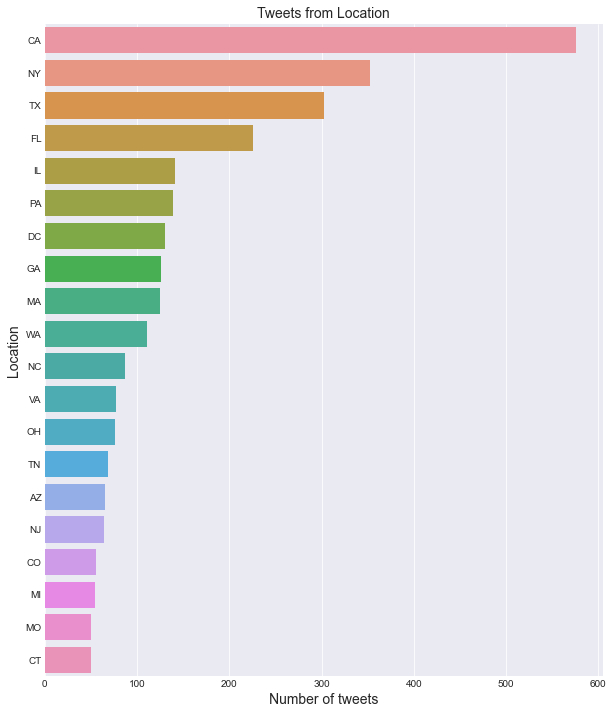

In [110]:
plt.figure(figsize=(10,12))
sns.barplot(df.us_state.value_counts().values[0:20],
            df.us_state.value_counts().index[0:20]);
plt.title("Tweets from Location",fontsize=14)
plt.xlabel("Number of tweets",fontsize=14)
plt.ylabel("Location",fontsize=14)
plt.show()

Text(0, 0.5, 'Origin of Tweets')

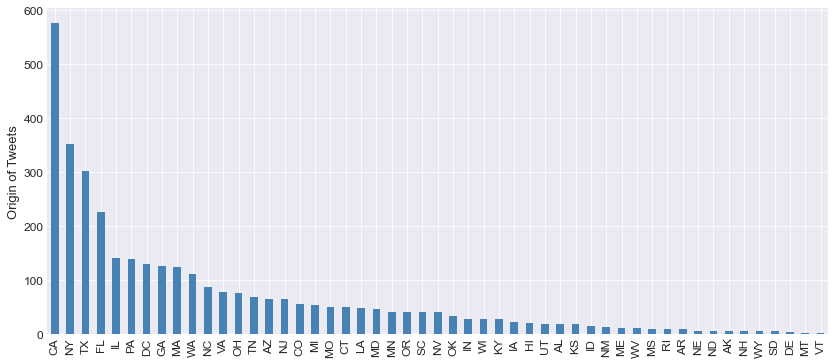

In [112]:
# plot tweets distribution by state
plt.style.use('seaborn-darkgrid')
x = df.us_state.value_counts()
x.plot(kind='bar',figsize=(14,6),fontsize=12,color='steelblue')
plt.ylabel('Origin of Tweets', fontsize=13)

In [113]:
import plotly.offline as pyo
import plotly.graph_objs as go

In [114]:
from IPython.display import IFrame

In [118]:
# Create the sentiment by state Heat Map
colorscale=[
            [0, 'rgb(31,120,180)'], 
            [0.35, 'rgb(166, 206, 227)'], 
            [0.75, 'rgb(251,154,153)'], 
            [1, 'rgb(227,26,28)']
           ]
data = dict(type='choropleth',
            colorscale = colorscale,
            reversescale=True,
            locations = df['us_state'],
            z = df_unanim['mean_score'],
            locationmode = 'USA-states',
            text = df['us_state'],
            marker = dict(line = dict(color = 'rgb(255,255,255)',width = 2)),
            colorbar = {'title':"Twitter Sentiment"}
            )
layout = dict(title = 'Tweet Sentiment by Federal States',
              geo = dict(scope='usa'
                        )
             )
choromap_us = go.Figure(data = [data],layout = layout)
#plotly.offline.plot(choromap_us, filename='img_map.html')  # save html map
IFrame('img_map.html', width=950, height=700)  # view saved map html file

In [119]:
choromap_us.show()

In [55]:
from urllib.request import urlopen
import json
with urlopen('https://raw.githubusercontent.com/plotly/datasets/master/geojson-counties-fips.json') as response:
    counties = json.load(response)

In [120]:
from urllib.request import urlopen
import json
with urlopen('https://raw.githubusercontent.com/plotly/datasets/master/geojson-counties-fips.json') as response:
    counties = json.load(response)

import pandas as pd
df = pd.read_csv("https://raw.githubusercontent.com/plotly/datasets/master/fips-unemp-16.csv",
                   dtype={"fips": str})

import plotly.express as px

fig = px.choropleth(df_unanim, geojson=counties, locations=df['us_state'], color=df['mean_score'],
                           color_continuous_scale="Viridis",
                           range_color=(0, 12),
                           scope="usa",
                           labels={'unemp':'unemployment rate'}
                          )
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.show()

KeyError: 'us_state'